In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

torch.backends.cudnn.deterministic=True
device = torch.device("cuda")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ~~ MNIST ~~

transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(root='/content/gdrive/My Drive/Datasets/MNIST', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='/content/gdrive/My Drive/Datasets/MNIST', train=False, download=True, transform=transform)

In [0]:
# MNIST

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

In [0]:
class ConvolutionalNeuralNetwork(nn.Module):
    
    
    def __init__(self):
        
        super().__init__()

        m = 10  
            
        # ~~ SmallVGGNET ~~ #
            
        # Block #1   
            
        self.conv1 = nn.Conv2d(1, 16, 3, padding=3)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
            
            
        # Block #2 
            
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
            
            
        # Block #3
            
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
            
            
        # Block #4
            
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, m)
        
        # Xavier Initialization
        
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.xavier_uniform_(self.conv4.weight)
        nn.init.xavier_uniform_(self.conv5.weight)
        nn.init.xavier_uniform_(self.conv6.weight)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        
        out = F.relu( self.conv1(x) )
        out = F.relu( self.conv2(out) )
        out = F.max_pool2d(out, 2)
            
        out = F.relu( self.conv3(out) )
        out = F.relu( self.conv4(out) )
        out = F.max_pool2d(out, 2)

        out = F.relu( self.conv5(out) )
        out = F.relu( self.conv6(out) )
        out = F.max_pool2d(out, 2)

        out = out.view(out.size(0), -1)

        out = F.relu( self.fc1(out) )
        out = F.relu( self.fc2(out) )
        out = self.fc3(out)
        
        return out

In [0]:
class Model:
    
    def __init__(self, architecture):
        
        self.net = architecture
    
    def train(self, train_loader, test_loader, nb_epochs=10):
        
        self.net.train()
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr=0.03)
        
        train_accuracy = []
        train_er = []
        
        test_accuracy = []
        test_er = []
        
        # Record train values
        train_accuracy_epoch, train_er_epoch = self.test(train_loader)
        
        print(train_er_epoch)
        print(train_accuracy_epoch)
            
        train_accuracy.append(train_accuracy_epoch)
        train_er.append(train_er_epoch)
                    
        # Record test values
        test_accuracy_epoch, test_er_epoch = self.test(test_loader)
            
        test_accuracy.append(test_accuracy_epoch)
        test_er.append(test_er_epoch)
        
        print(test_er_epoch)
        print(test_accuracy_epoch)
        
        # Start training
        
        for epoch in range(nb_epochs):
            
            print('\nEpoch', epoch+1)
     
            for i, (X_batch, y_batch) in enumerate(train_loader):
        
                # Send the batch to the GPU
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Reset the gradients to zero
                optimizer.zero_grad()
        
                # Forward propagation
                y_hat_batch = self.net(X_batch)
        
                # Compute loss
                loss = criterion(y_hat_batch, y_batch)
            
                # Backward propagation
                loss.backward()
            
                # Update weights
                optimizer.step()
                
            # Record train values
            train_accuracy_epoch, train_er_epoch = self.test(train_loader)
            
            print(train_er_epoch)
            print(train_accuracy_epoch)
            
            train_accuracy.append(train_accuracy_epoch)
            train_er.append(train_er_epoch)
                    
            # Record test values
            test_accuracy_epoch, test_er_epoch = self.test(test_loader)
            
            test_accuracy.append(test_accuracy_epoch)
            test_er.append(test_er_epoch)
            
            print(test_er_epoch)
            print(test_accuracy_epoch)
                               
        return train_accuracy, train_er, test_accuracy, test_er
            
    def test(self, data_loader):
        
        self.net.eval()
        
        criterion = nn.CrossEntropyLoss()
        
        with torch.no_grad():
        
            accuracy = 0
            correct_predictions = 0
            empirical_risk = 0
            
            for X_batch, y_batch in data_loader:
            
                # Send the batch to the GPU
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
                # Forward propagation
                y_hat_batch = self.net(X_batch)
                
                # Compute loss
                loss = criterion(y_hat_batch, y_batch)
            
                # Pick up most predicted class
                _, predictions = torch.max(y_hat_batch.data, 1)
                
                # Compare predictions and real label
                correct_predictions += (predictions == y_batch).sum().item()
                
                # Sum losses
                empirical_risk += loss
    
        
        accuracy = (correct_predictions / len(data_loader.dataset)) * 100
        empirical_risk /= len(data_loader)
        
        return accuracy, empirical_risk

In [22]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

cnn = ConvolutionalNeuralNetwork().to(device)

model = Model(cnn)

train_accuracy, train_er, test_accuracy, test_er = model.train(train_loader, test_loader)

tensor(2.3039, device='cuda:0')
9.93
tensor(2.3031, device='cuda:0')
10.32

Epoch 1
tensor(0.2133, device='cuda:0')
93.11833333333334
tensor(0.2029, device='cuda:0')
93.31

Epoch 2
tensor(0.0827, device='cuda:0')
97.55833333333334
tensor(0.0797, device='cuda:0')
97.44

Epoch 3
tensor(0.0609, device='cuda:0')
98.06166666666667
tensor(0.0644, device='cuda:0')
97.69

Epoch 4
tensor(0.0430, device='cuda:0')
98.67166666666667
tensor(0.0508, device='cuda:0')
98.36

Epoch 5
tensor(0.0295, device='cuda:0')
99.08
tensor(0.0417, device='cuda:0')
98.56

Epoch 6
tensor(0.0240, device='cuda:0')
99.24333333333333
tensor(0.0365, device='cuda:0')
98.71

Epoch 7
tensor(0.0273, device='cuda:0')
99.11166666666666
tensor(0.0443, device='cuda:0')
98.54

Epoch 8
tensor(0.0218, device='cuda:0')
99.23166666666667
tensor(0.0375, device='cuda:0')
98.77

Epoch 9
tensor(0.0178, device='cuda:0')
99.40833333333333
tensor(0.0385, device='cuda:0')
98.72999999999999

Epoch 10
tensor(0.0099, device='cuda:0')
99.7299999

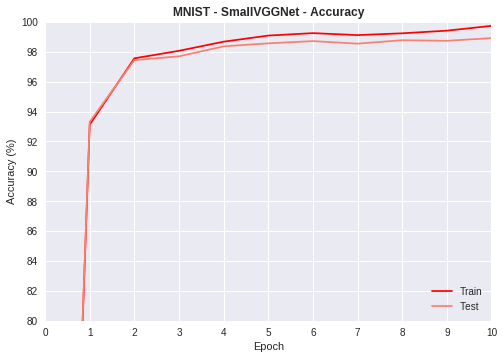

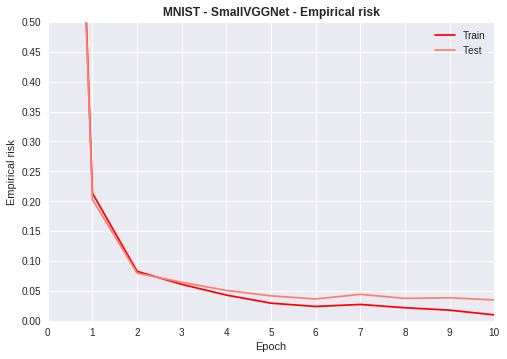

In [32]:
plt.xticks(np.arange(0,11))
plt.yticks(np.arange(80,101,2))
plt.ylim(80,100)
plt.xlim(0,10)

plt.plot(train_accuracy, label='Train', color='red')
plt.plot(test_accuracy, label='Test', color='salmon')

plt.title('MNIST - SmallVGGNet - Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc=4)
plt.show()

plt.clf()

plt.xticks(np.arange(0,11))
plt.yticks(np.arange(0,0.51,0.05))
plt.ylim(0,0.5)
plt.xlim(0,10)

plt.plot(train_er, label='Train', color='red')
plt.plot(test_er, label='Test', color='salmon')

plt.title('MNIST - SmallVGGNet - Empirical risk', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Empirical risk')
plt.legend(loc=1)
plt.show()